In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir 'yolov8_db'
!mkdir 'yolov8_db/dataset'
!mkdir 'yolov8_db/dataset/train'
!mkdir 'yolov8_db/dataset/valid'
!mkdir 'yolov8_db/dataset/train/images'
!mkdir 'yolov8_db/dataset/valid/images'
!mkdir 'yolov8_db/dataset/train/labels'
!mkdir 'yolov8_db/dataset/valid/labels'

In [4]:
%%capture
!pip install ultralytics==8.0.106
!pip install --upgrade albumentations bounding_box

# Librerie

In [5]:
import re, sys, glob, time, os, math, random, shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
from bounding_box import bounding_box as bb
from google.colab.patches import cv2_imshow

from PIL import Image
import cv2 as cv

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *

import tensorflow as tf
import ultralytics

torch.__version__, A.__version__, ultralytics.__version__

('2.0.1+cu118', '1.3.0', '8.0.106')

# Immagini

In [6]:
path_to_images = tf.keras.utils.get_file("images", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", untar=True)
path_to_annotations = tf.keras.utils.get_file("annotations", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", untar=True)

19173078/19173078 [==============================] - 1s 0us/step


In [10]:
def xml_to_csv(pths):
  xml_list = []
  for xml_file in tqdm(pths):
    tree = ET.parse(f'{path_to_annotations}/xmls/{xml_file}')
    root = tree.getroot()
    filename = root.find("filename").text
    size = root.findall('size')[0]
    obj = root.findall("object")[0][4]
    xml_list.append([
      f'{path_to_images}/{filename}',  # the path to the image
      '_'.join(filename.split('_')[:-1]).lower(), # get class from filename
      int(size[0].text), # get width
      int(size[1].text), # get height
      float(obj[0].text), # 1. xmin
      float(obj[1].text), # 2. ymin
      float(obj[2].text), # 3. xmax
      float(obj[3].text), # 4. ymax
    ])
  return pd.DataFrame(xml_list, columns=["filename", "class", "width", "height", "xmin", "ymin", "xmax", "ymax"])

dim = 640
df = xml_to_csv(os.listdir("/root/.keras/datasets/annotations/xmls"))

le = LabelEncoder()
df["target"] = le.fit_transform(df["class"].values)
df.head()

  0%|          | 0/3686 [00:00<?, ?it/s]

filename             class  width  \
0    /root/.keras/datasets/images/Abyssinian_135.jpg        abyssinian    333   
1  /root/.keras/datasets/images/scottish_terrier_...  scottish_terrier    500   
2    /root/.keras/datasets/images/pomeranian_162.jpg        pomeranian    222   
3  /root/.keras/datasets/images/Russian_Blue_177.jpg      russian_blue    500   
4   /root/.keras/datasets/images/Egyptian_Mau_15.jpg      egyptian_mau    500   

   height   xmin  ymin   xmax   ymax  target  
0     500   20.0  58.0  257.0  278.0       0  
1     375  186.0   2.0  348.0  286.0      30  
2     300   19.0  32.0  123.0  129.0      24  
3     281  108.0  13.0  207.0  109.0      27  
4     334  243.0  93.0  338.0  191.0      11

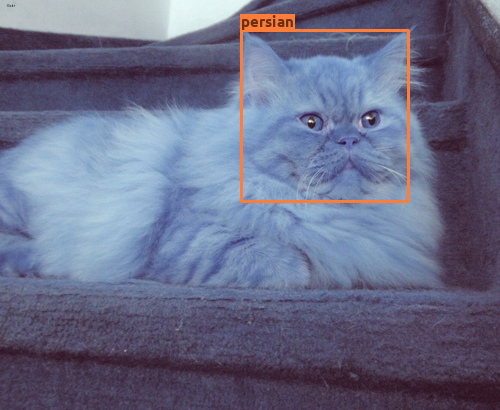

In [20]:
def view_rndm_sample(name, color="orange", random=True):
  if random:
    n = np.random.randint(0, len(name))
    im = cv.cvtColor(cv.imread(name.filename[n]), cv.COLOR_BGR2RGB)
    bb.add(im, name["xmin"][n], name["ymin"][n], name["xmax"][n], name["ymax"][n], name["class"][n], color=color)
  else:
    im = cv.cvtColor(cv.imread(name), cv.COLOR_BGR2RGB)
    n = np.where(df['filename'] == name)[0][0]
    bb.add(im, df.loc[n, "xmin"], df.loc[n, "ymin"], df.loc[n, "xmax"], df.loc[n, "ymax"], df.loc[n, "class"], color=color)
  cv2_imshow(im)

view_rndm_sample(df)

In [21]:
# # Transform the bbox co-ordinates (pascal voc) per the format required by YOLO
df["b_center_x"] = (df["xmax"] + df["xmin"]) / (2 * df["width"])
df["b_center_y"] = (df["ymax"] + df["ymin"]) / (2 * df["height"])
df["b_width"] = (df["xmax"] - df["xmin"]) / df["width"]
df["b_height"] = (df["ymax"] - df["ymin"]) / df["height"]

train, valid = train_test_split(df, test_size=0.1, stratify=df['target'])

train_ids = train['filename'].tolist()
valid_ids = valid['filename'].tolist()

print(len(train_ids), len(valid_ids))
train.head()

3317 369


filename               class  \
261         /root/.keras/datasets/images/beagle_176.jpg              beagle   
3059    /root/.keras/datasets/images/leonberger_179.jpg          leonberger   
3070        /root/.keras/datasets/images/Sphynx_121.jpg              sphynx   
931   /root/.keras/datasets/images/miniature_pinsche...  miniature_pinscher   
2616  /root/.keras/datasets/images/english_setter_18...      english_setter   

      width  height   xmin   ymin   xmax   ymax  target  b_center_x  \
261     379     500   46.0   46.0  331.0  335.0       4    0.497361   
3059    459     500    1.0   21.0  450.0  417.0      19    0.491285   
3070    334     500  145.0   62.0  287.0  209.0      33    0.646707   
931     500     492  151.0   20.0  296.0  191.0      21    0.447000   
2616    500     333   59.0  137.0  166.0  222.0      13    0.225000   

      b_center_y   b_width  b_height  
261     0.381000  0.751979  0.578000  
3059    0.438000  0.978214  0.792000  
3070    0.271000  0.425150  0.294000  
931     0.214431  0.290000  0.347561  
2616    0.539039  0.214000  0.255255

In [22]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder, folder='images_resample', is_image=True):
  for f in tqdm(list_of_files):
    if is_image is True:
      shutil.copy(f, destination_folder)
    else:
      tmp = df[df['filename'] == f][['target', 'b_center_x', 'b_center_y', 'b_width', 'b_height']]
      tmp.to_csv(destination_folder + '/' + f.split('/')[-1][:-4] + '.txt', header=None, index=None, sep=' ', mode='w')

# Move the splits into their folders
print('Images')
move_files_to_folder(train_ids, '/content/yolov8_db/dataset/train/images', is_image=True)
move_files_to_folder(valid_ids, '/content/yolov8_db/dataset/valid/images', is_image=True)
print('Annotations')
move_files_to_folder(train_ids, '/content/yolov8_db/dataset/train/labels', is_image=False)
move_files_to_folder(valid_ids, '/content/yolov8_db/dataset/valid/labels', is_image=False)

s = f"path: '/content/yolov8_db/dataset'\ntrain: 'train'\nval: 'valid'\nnc: {len(list(le.classes_))}\nnames: {list(le.classes_)}"
text_file = open("/content/yolov8_db/dataset/data.yaml", "w")
n = text_file.write(s)
text_file.close()

Images


  0%|          | 0/3317 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

Annotations


  0%|          | 0/3317 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]

# Model

In [23]:
# Load a model
model = ultralytics.YOLO('yolov8s.yaml').load('yolov8s.pt')  # build from YAML and transfer weights
# Train the model
model.train(
    data='/content/yolov8_db/dataset/data.yaml',
    epochs=15,
    batch=24,
    imgsz=dim,
    label_smoothing=0.1,
    )


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [24]:
shutil.copy('runs/detect/train/weights/best.pt', '/content/drive/MyDrive/Colab Notebooks/Telegram - Cat Dog Classification')

'/content/drive/MyDrive/Colab Notebooks/Telegram - Cat Dog Classification/best.pt'

# Risultati

In [25]:
test_image_path = os.listdir(path_to_images)
model = ultralytics.YOLO('/content/drive/MyDrive/Colab Notebooks/Telegram - Cat Dog Classification/best.pt')  # load a custom trained


image 1/1 /root/.keras/datasets/images/Birman_83.jpg: 448x640 1 birman, 75.4ms
Speed: 2.5ms preprocess, 75.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Birman_83.jpg
[     201.13      12.723      425.46         226] birman 0.92


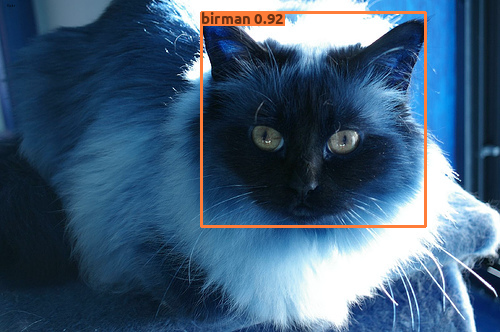

In [26]:
name = test_image_path[np.random.randint(0, len(test_image_path))]
results = model.predict(path_to_images + f'/{name}')

print(name)
debug = True
if debug:
  dict_name = results[0].names
  box = results[0].boxes.xyxy.cpu().numpy()[0]
  cls = dict_name[results[0].boxes.cls.cpu().numpy()[0]] + ' ' + str(round(results[0].boxes.conf.cpu().numpy()[0], 2))
  print(box, cls)
  im = cv.cvtColor(cv.imread(path_to_images + f'/{name}'), cv.COLOR_BGR2RGB)
  bb.add(im, box[0], box[1], box[2], box[3], cls, color='orange')
  cv2_imshow(im)
else:
  res_plotted = results[0].plot()
  cv2_imshow(res_plotted)